In [7]:
import pdfplumber
import pandas as pd

def make_column_names_unique(cols):
    seen = {}
    new_cols = []
    for col in cols:
        if col in seen:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
        else:
            seen[col] = 0
            new_cols.append(col)
    return new_cols

pdf_path = "Tradexa Internship Assignment_ Data Science - Dataset (1).pdf"
output_csv = "tradexa_dataset.csv"

all_tables = []

with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        tables = page.extract_tables()
        for table in tables:
            if table and len(table) > 1:
                df = pd.DataFrame(table[1:], columns=make_column_names_unique(table[0]))
                all_tables.append(df)

if all_tables:
    try:
        final_df = pd.concat(all_tables, ignore_index=True)
        final_df.to_csv(output_csv, index=False)
        print("✅ Data extracted and saved to:", output_csv)
    except Exception as e:
        print("❌ Concatenation error:", e)
else:
    print("❌ No tables found in the PDF.")


✅ Data extracted and saved to: tradexa_dataset.csv


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Load the cleaned CSV from the PDF extraction
df = pd.read_csv("tradexa_dataset.csv")

# Basic cleaning - remove rows with missing target or key features
df = df.dropna(subset=["3YrReturn%", "Market Cap", "Type", "Risk"])

# Convert 3YrReturn% to numeric (handle % if needed)
df["3YrReturn%"] = df["3YrReturn%"].astype(str).str.replace("%", "").astype(float)

# Optional: Drop duplicates
df = df.drop_duplicates()

# Features and target
X = df[["Market Cap", "Type", "Risk"]]
y = df["3YrReturn%"]

# One-hot encode categorical variables
categorical_features = ["Market Cap", "Type", "Risk"]
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Build pipeline with Random Forest
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("✅ Model Evaluation Metrics:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Feature importance (from Random Forest)
importances = model.named_steps['regressor'].feature_importances_
feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\n📊 Feature Importances:")
print(feature_importance_df)

# ✅ Best performing categories (optional insight)
X_encoded = model.named_steps["preprocessor"].transform(X)
y_pred_all = model.predict(X)

best_rows = df.copy()
best_rows["Predicted 3YrReturn%"] = y_pred_all
top_allocations = best_rows.sort_values("Predicted 3YrReturn%", ascending=False).head(10)

print("\n🚀 Top 10 Asset Allocations for Maximum 3YrReturn%:")
print(top_allocations[["Market Cap", "Type", "Risk", "Predicted 3YrReturn%"]])


✅ Model Evaluation Metrics:
R² Score: -0.631
RMSE: 2.16
MAE: 1.81

📊 Feature Importances:
              Feature  Importance
4        Risk_Average    0.248074
1  Market Cap_Mid-Cap    0.177341
0    Market Cap_Large    0.154539
5           Risk_High    0.126972
6            Risk_Low    0.114285
2         Type_Growth    0.098680
3          Type_Value    0.080109

🚀 Top 10 Asset Allocations for Maximum 3YrReturn%:
   Market Cap   Type     Risk  Predicted 3YrReturn%
33    Mid-Cap  Value  Average             20.763436
16    Mid-Cap  Value  Average             20.763436
22    Mid-Cap  Value  Average             20.763436
3     Mid-Cap  Value  Average             20.763436
27    Mid-Cap  Value  Average             20.763436
36    Mid-Cap  Value  Average             20.763436
28    Mid-Cap  Value  Average             20.763436
17    Mid-Cap  Value  Average             20.763436
1       Large  Value  Average             18.775095
39      Large  Value  Average             18.775095


In [9]:
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Mean R²:", scores.mean())


Cross-validated R² scores: [-0.8516175   0.50659765 -1.03751437  0.01167087 -0.81688843]
Mean R²: -0.4375503567401456


In [10]:
print(df.groupby("Risk")["3YrReturn%"].mean().sort_values(ascending=False))
print(df.groupby("Type")["3YrReturn%"].mean().sort_values(ascending=False))


Risk
Average    18.851212
Low        16.618889
High       12.630000
Name: 3YrReturn%, dtype: float64
Type
Value     18.467000
Growth    18.041304
Name: 3YrReturn%, dtype: float64


C:\Users\Shilpi Chadokar\AppData\Local\Temp\ipykernel_11904\1321418154.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Risk", y="3YrReturn%", ci=None, palette="Set2")
C:\Users\Shilpi Chadokar\AppData\Local\Temp\ipykernel_11904\1321418154.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Risk", y="3YrReturn%", ci=None, palette="Set2")


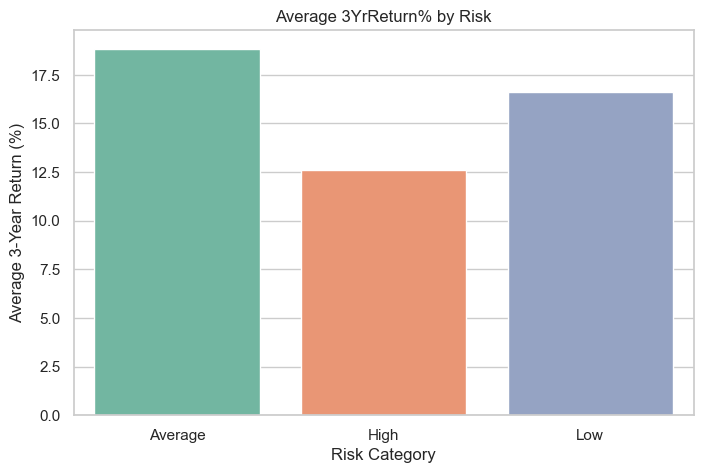

C:\Users\Shilpi Chadokar\AppData\Local\Temp\ipykernel_11904\1321418154.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Market Cap", y="3YrReturn%", ci=None, palette="pastel")
C:\Users\Shilpi Chadokar\AppData\Local\Temp\ipykernel_11904\1321418154.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Market Cap", y="3YrReturn%", ci=None, palette="pastel")


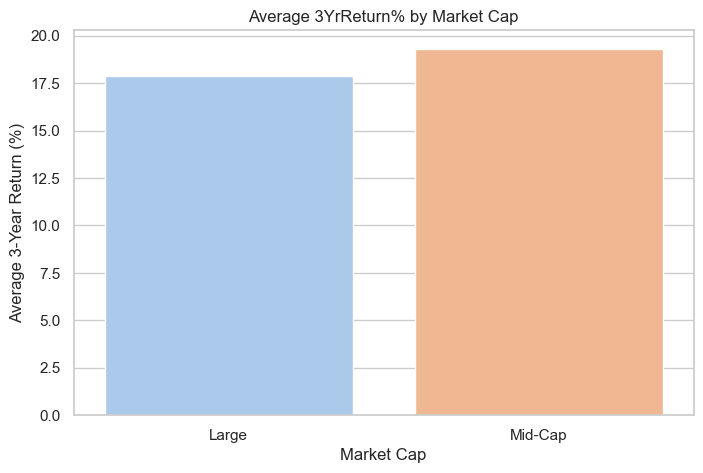

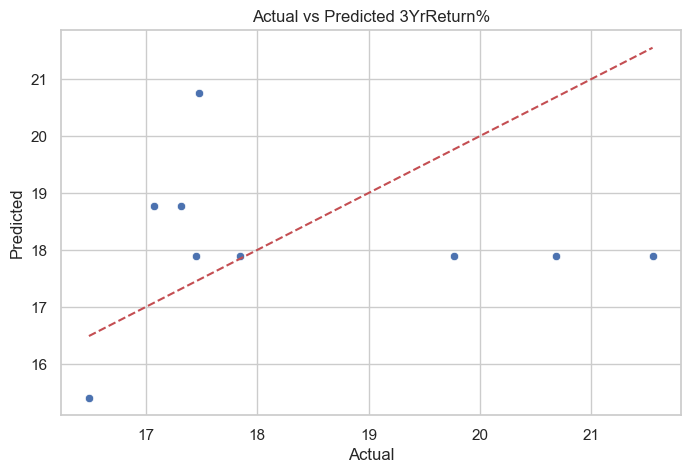

C:\Users\Shilpi Chadokar\AppData\Local\Temp\ipykernel_11904\1321418154.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x="Importance", y="Feature", palette="viridis")


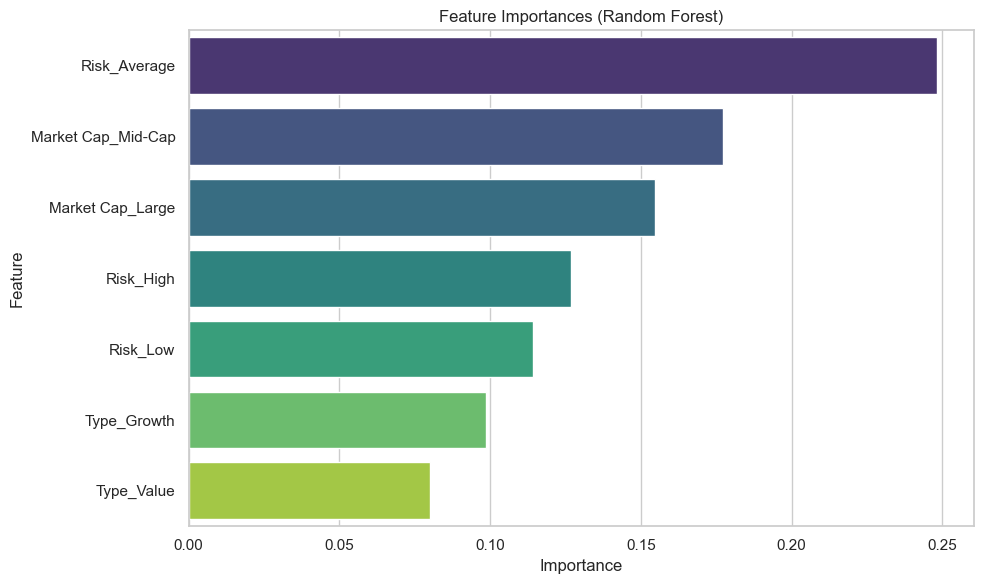

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# 1. Average Return by Risk Category
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Risk", y="3YrReturn%", ci=None, palette="Set2")
plt.title("Average 3YrReturn% by Risk")
plt.ylabel("Average 3-Year Return (%)")
plt.xlabel("Risk Category")
plt.show()

# 2. Average Return by Market Cap
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Market Cap", y="3YrReturn%", ci=None, palette="pastel")
plt.title("Average 3YrReturn% by Market Cap")
plt.ylabel("Average 3-Year Return (%)")
plt.xlabel("Market Cap")
plt.show()

# 3. Predicted vs Actual Returns
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Actual vs Predicted 3YrReturn%")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# 4. Feature Importance Chart
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


2025-04-07 23:09:22.712 
  command:

    streamlit run C:\Users\Shilpi Chadokar\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-07 23:09:22.713 No runtime found, using MemoryCacheStorageManager
2025-04-07 23:09:22.739 No runtime found, using MemoryCacheStorageManager


DeltaGenerator()

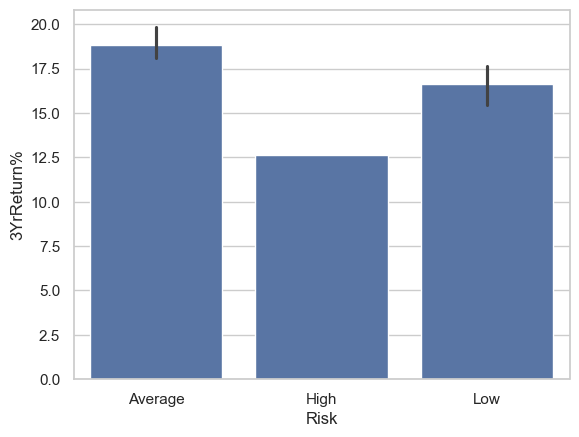

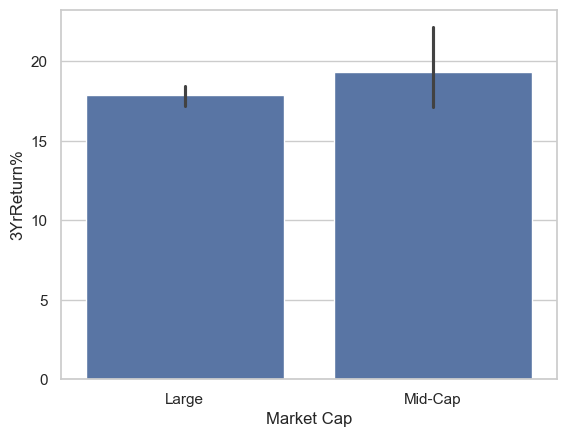

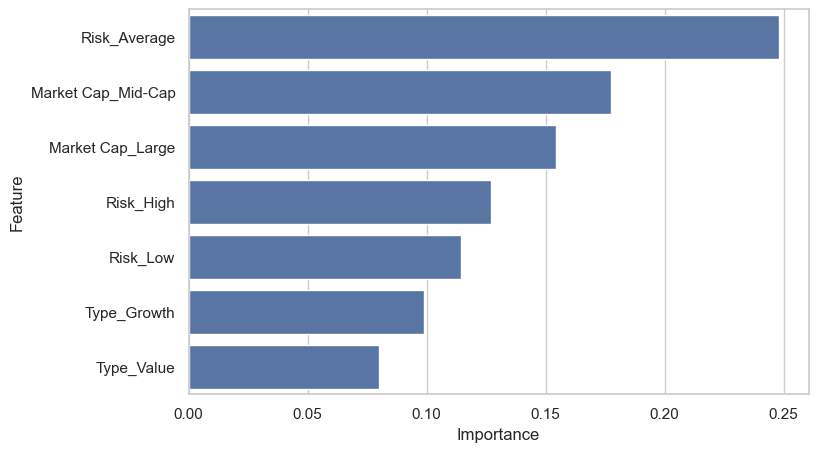

In [12]:
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

st.set_page_config(page_title="📊 Asset Allocation Optimizer", layout="wide")
st.title("📊 Asset Allocation Insights for Maximizing 3-Year Return")

# Load Data
@st.cache_data
def load_data():
    df = pd.read_csv("tradexa_dataset.csv")
    df = df.dropna(subset=["3YrReturn%", "Market Cap", "Type", "Risk"])
    df["3YrReturn%"] = df["3YrReturn%"].astype(str).str.replace("%", "").astype(float)
    return df

df = load_data()

# Sidebar filters
st.sidebar.header("🔎 Filter Options")
selected_risk = st.sidebar.multiselect("Select Risk Level:", df["Risk"].unique(), default=df["Risk"].unique())
selected_type = st.sidebar.multiselect("Select Type:", df["Type"].unique(), default=df["Type"].unique())
selected_marketcap = st.sidebar.multiselect("Select Market Cap:", df["Market Cap"].unique(), default=df["Market Cap"].unique())

filtered_df = df[
    df["Risk"].isin(selected_risk) &
    df["Type"].isin(selected_type) &
    df["Market Cap"].isin(selected_marketcap)
]

st.subheader("Filtered Data")
st.dataframe(filtered_df.reset_index(drop=True))

# Aggregated Visuals
st.subheader("📈 Average Return by Category")
col1, col2 = st.columns(2)

with col1:
    st.write("**By Risk**")
    fig, ax = plt.subplots()
    sns.barplot(data=filtered_df, x="Risk", y="3YrReturn%", ax=ax)
    st.pyplot(fig)

with col2:
    st.write("**By Market Cap**")
    fig, ax = plt.subplots()
    sns.barplot(data=filtered_df, x="Market Cap", y="3YrReturn%", ax=ax)
    st.pyplot(fig)

# Model Prediction
st.subheader("🧠 Predicting 3YrReturn%")
df_model = df[["Market Cap", "Type", "Risk", "3YrReturn%"]].copy()
df_encoded = pd.get_dummies(df_model.drop("3YrReturn%", axis=1))
y = df_model["3YrReturn%"]
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

st.markdown(f"**Model R² Score:** {r2:.2f}")
st.markdown(f"**Mean Squared Error:** {mse:.2f}")

# Feature Importances
feature_importance_df = pd.DataFrame({
    "Feature": df_encoded.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

st.subheader("📊 Feature Importances")
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=feature_importance_df, y="Feature", x="Importance", ax=ax)
st.pyplot(fig)

# Footer
st.markdown("---")
st.caption("Built with ❤️ using Streamlit | AI Data Scientist Project")
